<a href="https://colab.research.google.com/github/afloresblas/BigDataProject/blob/main/ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Big Data - Ray

In [3]:
# Dataset
# https://www.kaggle.com/rikdifos/credit-card-approval-prediction?select=credit_record.csv

# Tecnologias para el procesamiento
# 1. Ray
# Por presentar:
# Introducción / Avance 50% (Ingesta + EDA)
# IMPORTANTE: Usar %Time

# Imports

In [4]:
!pip install --user --ignore-installed funcsigs
!pip install ray 

     |████████████████████████████████| 54.7 MB 117 kB/s 
     |████████████████████████████████| 119 kB 52.9 MB/s 


In [5]:
import pandas as pd
import ray
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Entidades , Variables, Constantes

# Carga de Datos

In [6]:
# Mounting del drive con la data

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Ray

In [7]:
# Inicialización de Ray
ray.init(num_cpus=4, ignore_reinit_error=True)

{'metrics_export_port': 65357,
 'node_id': 'ff0f82dc5462994dfcca6850e319631ecf7f564762b17d40087bbf12',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-11-29_03-07-43_687974_60/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-11-29_03-07-43_687974_60/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-11-29_03-07-43_687974_60',
 'webui_url': None}

In [25]:
# Carga de datos - Funcion optimizada con Ray
%time
@ray.remote
def read_application():
  application_df = pd.read_csv('/content/gdrive/MyDrive/BigData/Proyecto/archive/application_record.csv')
  return application_df

@ray.remote
def read_credit():
  credit_df = pd.read_csv('/content/gdrive/MyDrive/BigData/Proyecto/archive/credit_record.csv')
  return credit_df

application_df = read_application.remote()
credit_df = read_credit.remote()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [27]:
%time
ray.get(application_df).head()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [28]:
%time
ray.get(credit_df).head()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.3 µs


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# Pre - Procesamiento (Limpieza)

In [35]:
# Análisis de valores duplicados
## Id's únicos dentro del dataframe df_application
%time
print("Cantidad de registros dentro de df_data:", ray.get(application_df).shape[0])
print("Cantidad de id's únicos dentro de df_data", ray.get(credit_df)['ID'].nunique())
## NO coincide la cantidad de registros únicos con la cantidad de registros dentro
## del dataframe

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Cantidad de registros dentro de df_data: 438510
Cantidad de id's únicos dentro de df_data 45985


In [36]:
## Los valores duplicados dentro del dataset serán eliminados

%time
@ray.remote
def drop_id_duplicates(df):
  return df.drop_duplicates('ID', keep = 'last')

application_df = drop_id_duplicates.remote(application_df)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [37]:
## Id's únicos dentro del dataframe df_record
%time
print("Cantidad de registros dentro de df_record:",ray.get(credit_df).shape[0])
print("Cantidad de id's únicos dentro de df_record",ray.get(credit_df)['ID'].nunique())
# NO coincide la cantidad de registros únicos con la cantidad de registros dentro
# porque son datos mensuales

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 17.6 µs
Cantidad de registros dentro de df_record: 1048575
Cantidad de id's únicos dentro de df_record 45985


In [39]:
## Número de id's que las dos tables comparten
%time
print(len(set(ray.get(application_df)["ID"]).intersection(set(ray.get(credit_df)["ID"]))))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
36457


In [40]:
# Análisis de valores nulos df_application
%time
print("-----------Análisis de valores nulos df_application-------------------")
print(ray.get(application_df).isnull().sum())

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
-----------Análisis de valores nulos df_application-------------------
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64


In [41]:
# El campo OCCUPATION_TYPE tiene gran cantidad de valores nulos
# no se tomará en cuenta este campo por dicha razón
ray.get(application_df).drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [42]:
# Análisis de valores nulos credit_df
%time
print("-----------Análisis de valores nulos df_record-------------------")
print(ray.get(credit_df).isnull().sum())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs
-----------Análisis de valores nulos df_record-------------------
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


In [44]:
# Unificación de las dos tablas
%time

@ray.remote
def dataframe_union(df1,df2):
  return df1.join(df2.set_index('ID'), on='ID', how='inner')

union = dataframe_union.remote(application_df, credit_df)
ray.get(union).info()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 0 to 434812
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  

In [46]:
# Eliminación de columnas que no se usarán para el análisis
ray.get(union).drop(columns=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], inplace=True)

In [48]:
%time
ray.get(union).head()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.5 µs
El 69% no tiene un vehículo


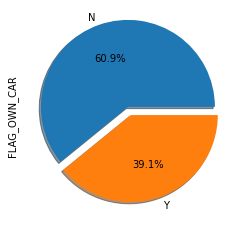

In [49]:
%time
print("El 69% no tiene un vehículo")
ray.get(union)['FLAG_OWN_CAR'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
Del total el 66.7% son mujeres


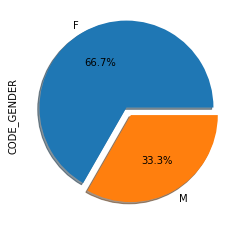

In [50]:
%time
print("Del total el 66.7% son mujeres")
ray.get(union)['CODE_GENDER'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


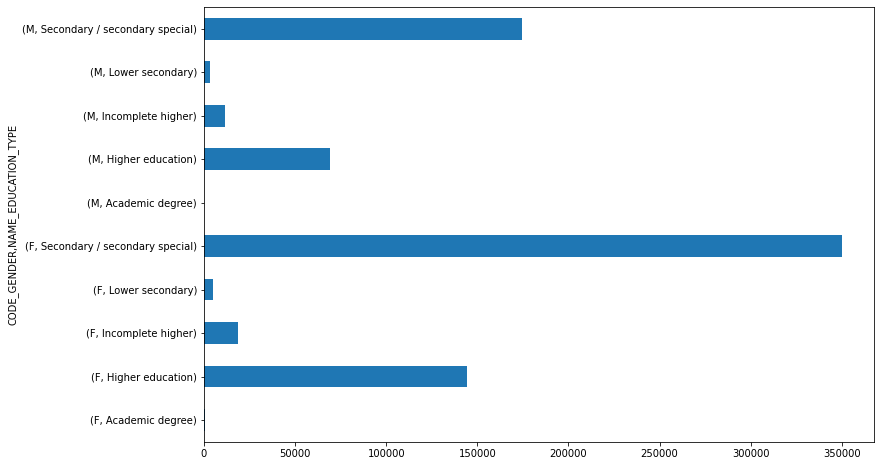

In [65]:
%time
ray.get(union).groupby(['CODE_GENDER', 'NAME_EDUCATION_TYPE']).size().plot(kind='barh', figsize = (12, 8))

In [71]:
## Cast de datos y eliminación de filas que contengan valores nuelo
%time
ray.get(union)['AMT_INCOME_TOTAL'] = ray.get(union)['AMT_INCOME_TOTAL'].astype('int')

@ray.remote
def drop_nulls(df):
  return df.dropna()

df_union = drop_nulls.remote(union)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Las familias que tienen dos hijos son las que mayor ingreso perciben


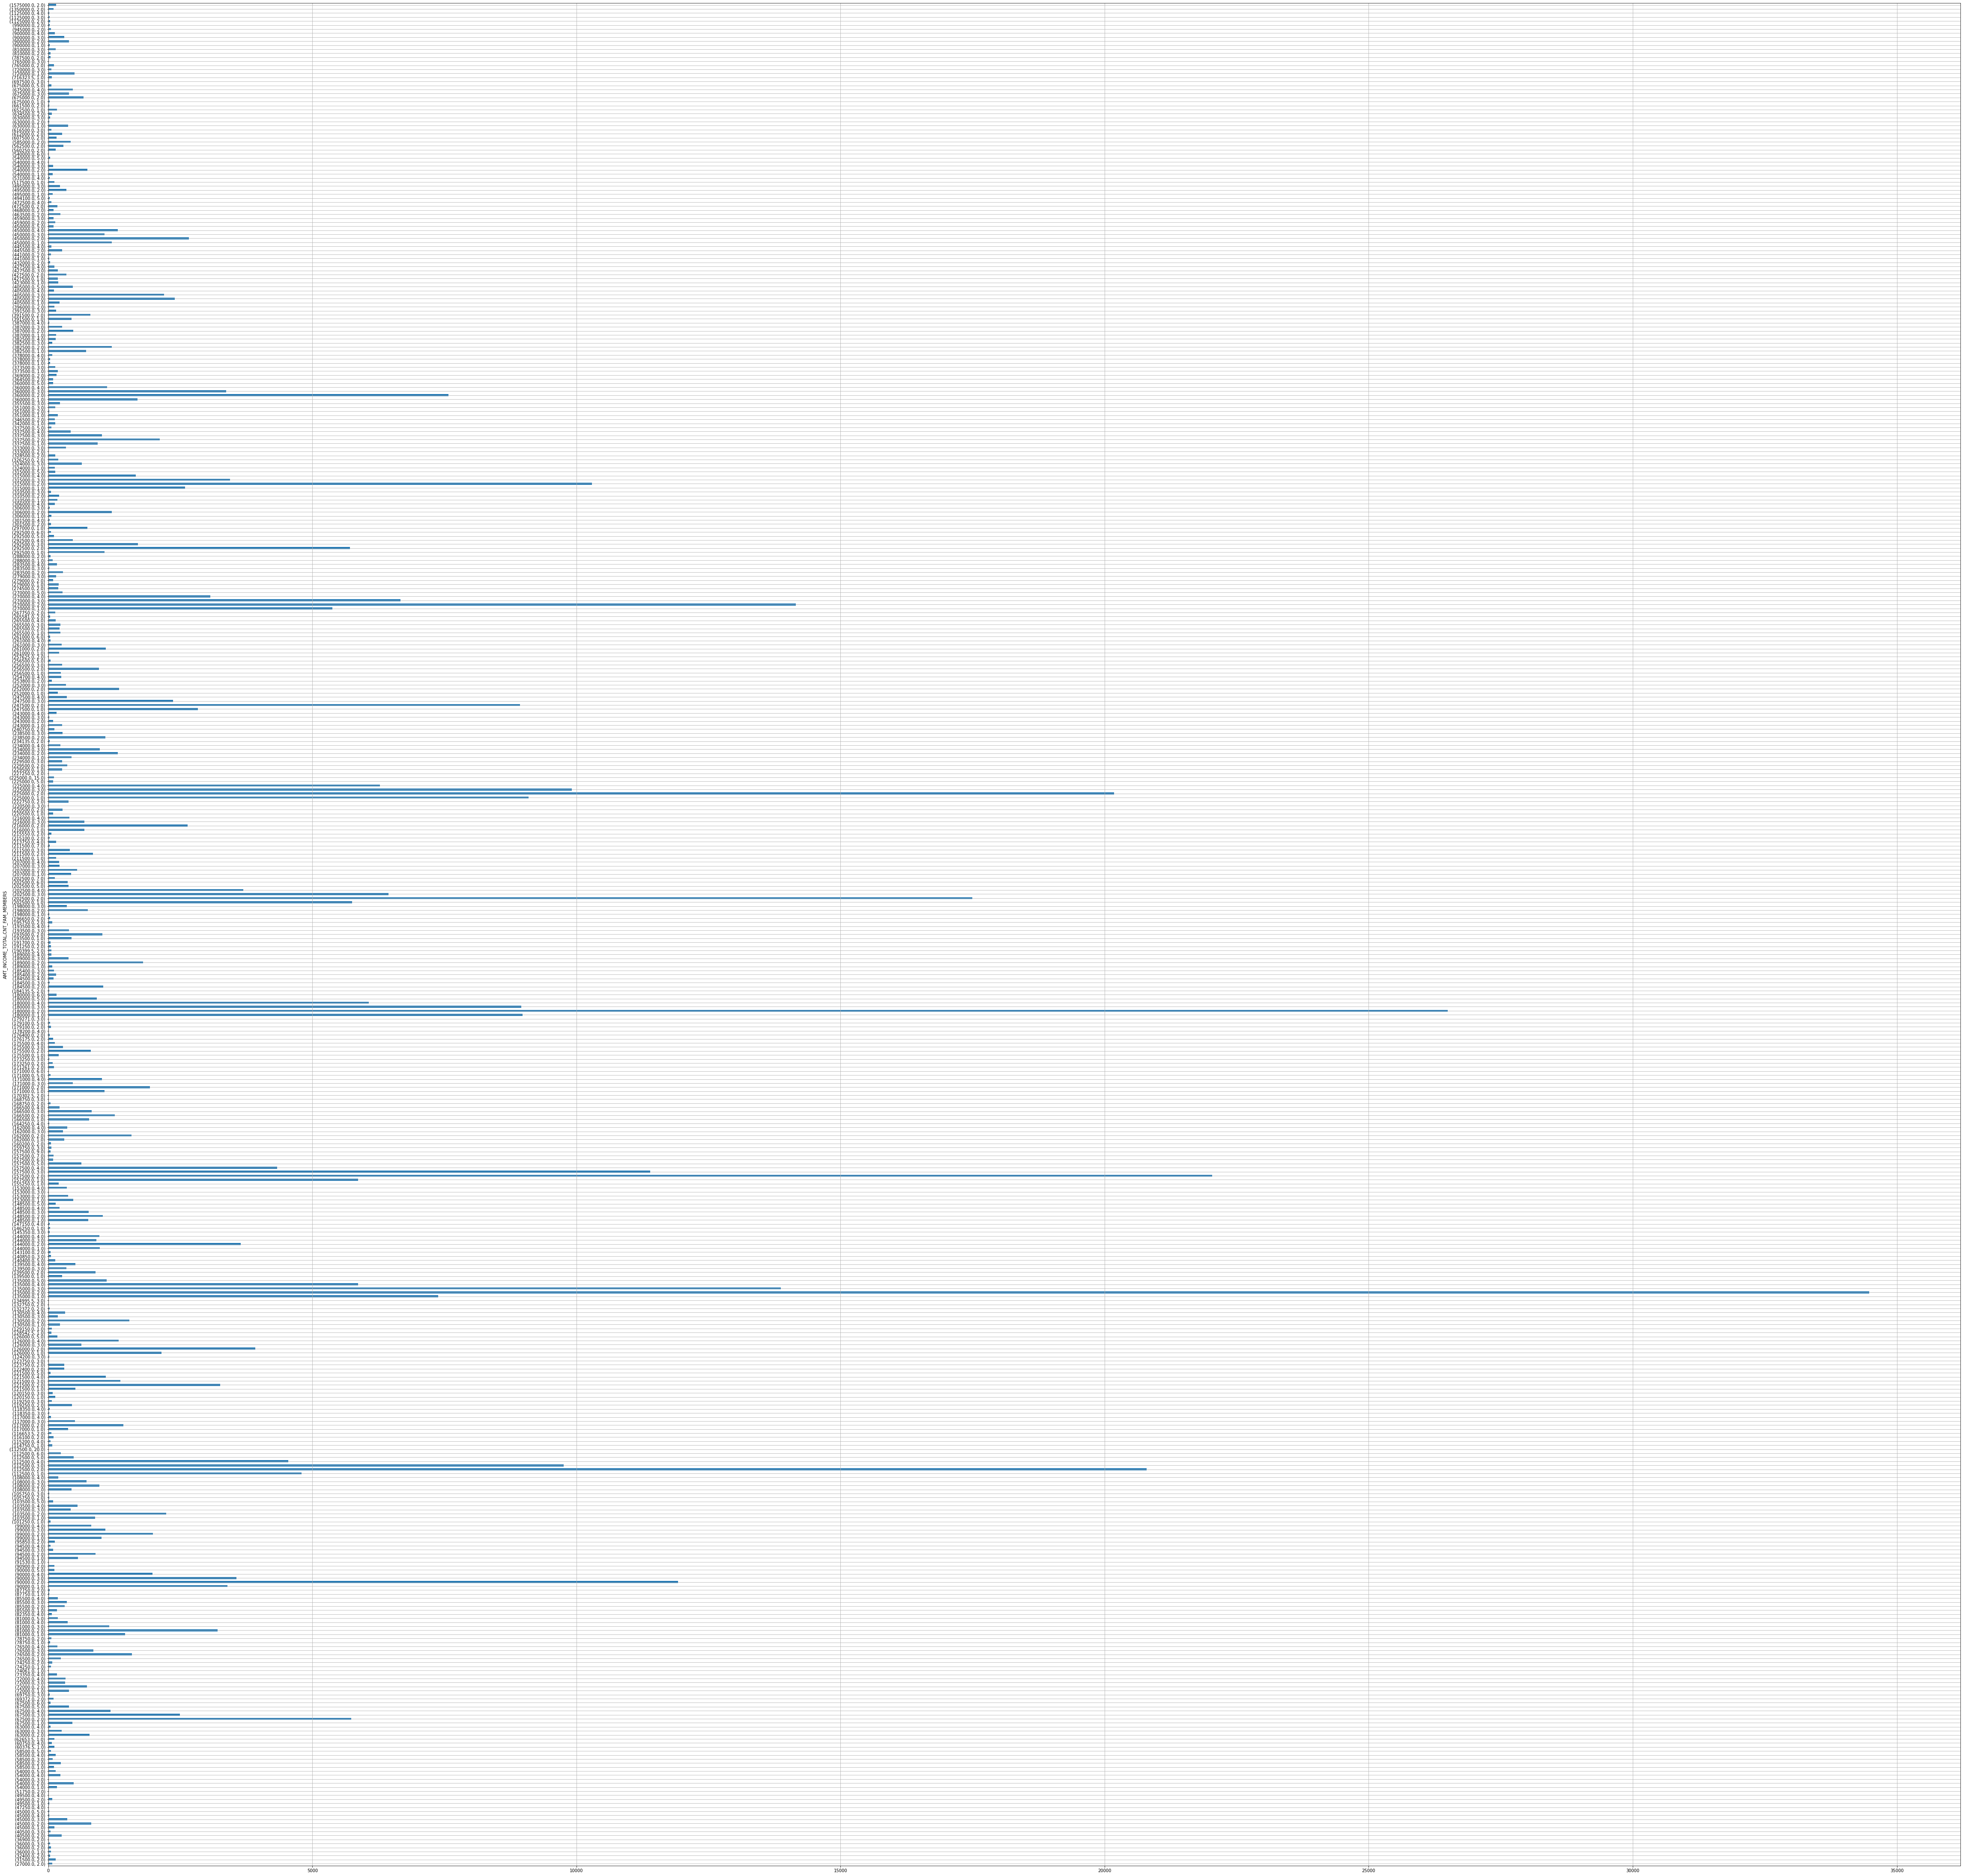

In [72]:
%time
print("Las familias que tienen dos hijos son las que mayor ingreso perciben")
ray.get(df_union).groupby(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']).size().plot(kind='barh', figsize=(80, 80), grid=True)